In [31]:
import multiprocessing
import random
import time

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchio as tio
from tqdm import tqdm
from torch.utils.data import DataLoader
from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import *
from scripts.load_data import *
from scripts.train import *

from miseval import evaluate


seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run on Sat Jul  8 22:24:07 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [35]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata.head(5)

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:17<00:00,  8.45it/s]


Training/Labeled/ Dataset size: 150 subjects
Total memory for train:  410.75 MB


100%|██████████| 33/33 [00:03<00:00,  9.32it/s]


Validation/ Dataset size: 33 subjects
Total memory for valid:  98.25 MB


100%|██████████| 134/134 [00:14<00:00,  9.00it/s]


Testing/ Dataset size: 134 subjects
Total memory for test:  400.00 MB
Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)


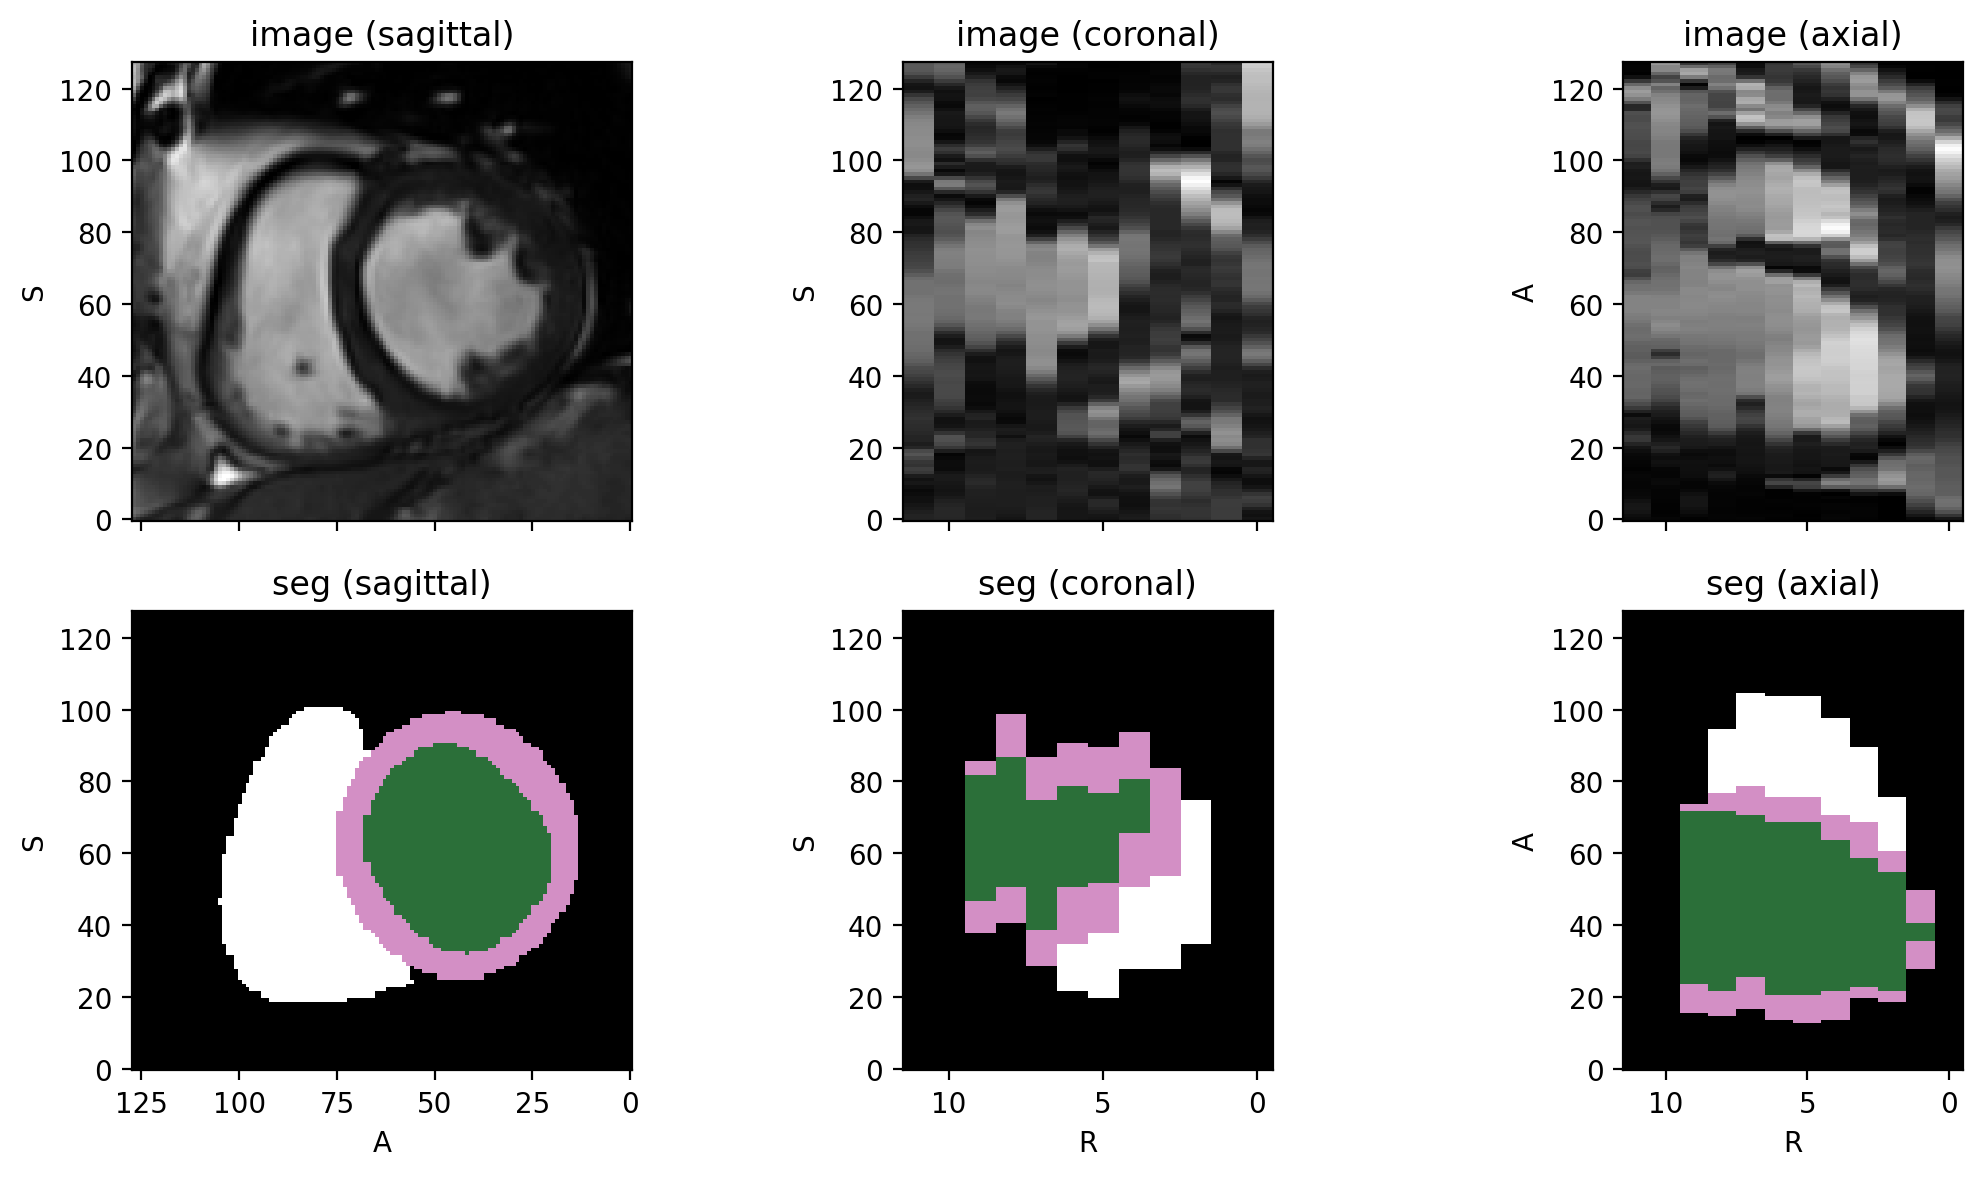

In [5]:
train_dataset_3D = load_3D("Labeled/")
print("Total memory for train: ", get_total_memory(train_dataset_3D))
valid_dataset_3D = load_3D("Validation/")
print("Total memory for valid: ", get_total_memory(valid_dataset_3D))
test_dataset_3D = load_3D("Testing/")
print("Total memory for test: ", get_total_memory(test_dataset_3D))


one_subject = train_dataset_3D[0]
visualize_subject(one_subject)

  3%|▎         | 4/150 [00:00<00:15,  9.20it/s]

100%|██████████| 150/150 [00:15<00:00,  9.54it/s]


Training/Labeled/ Dataset size: 3286 subjects


100%|██████████| 33/33 [00:03<00:00,  9.39it/s]


Validation/ Dataset size: 786 subjects


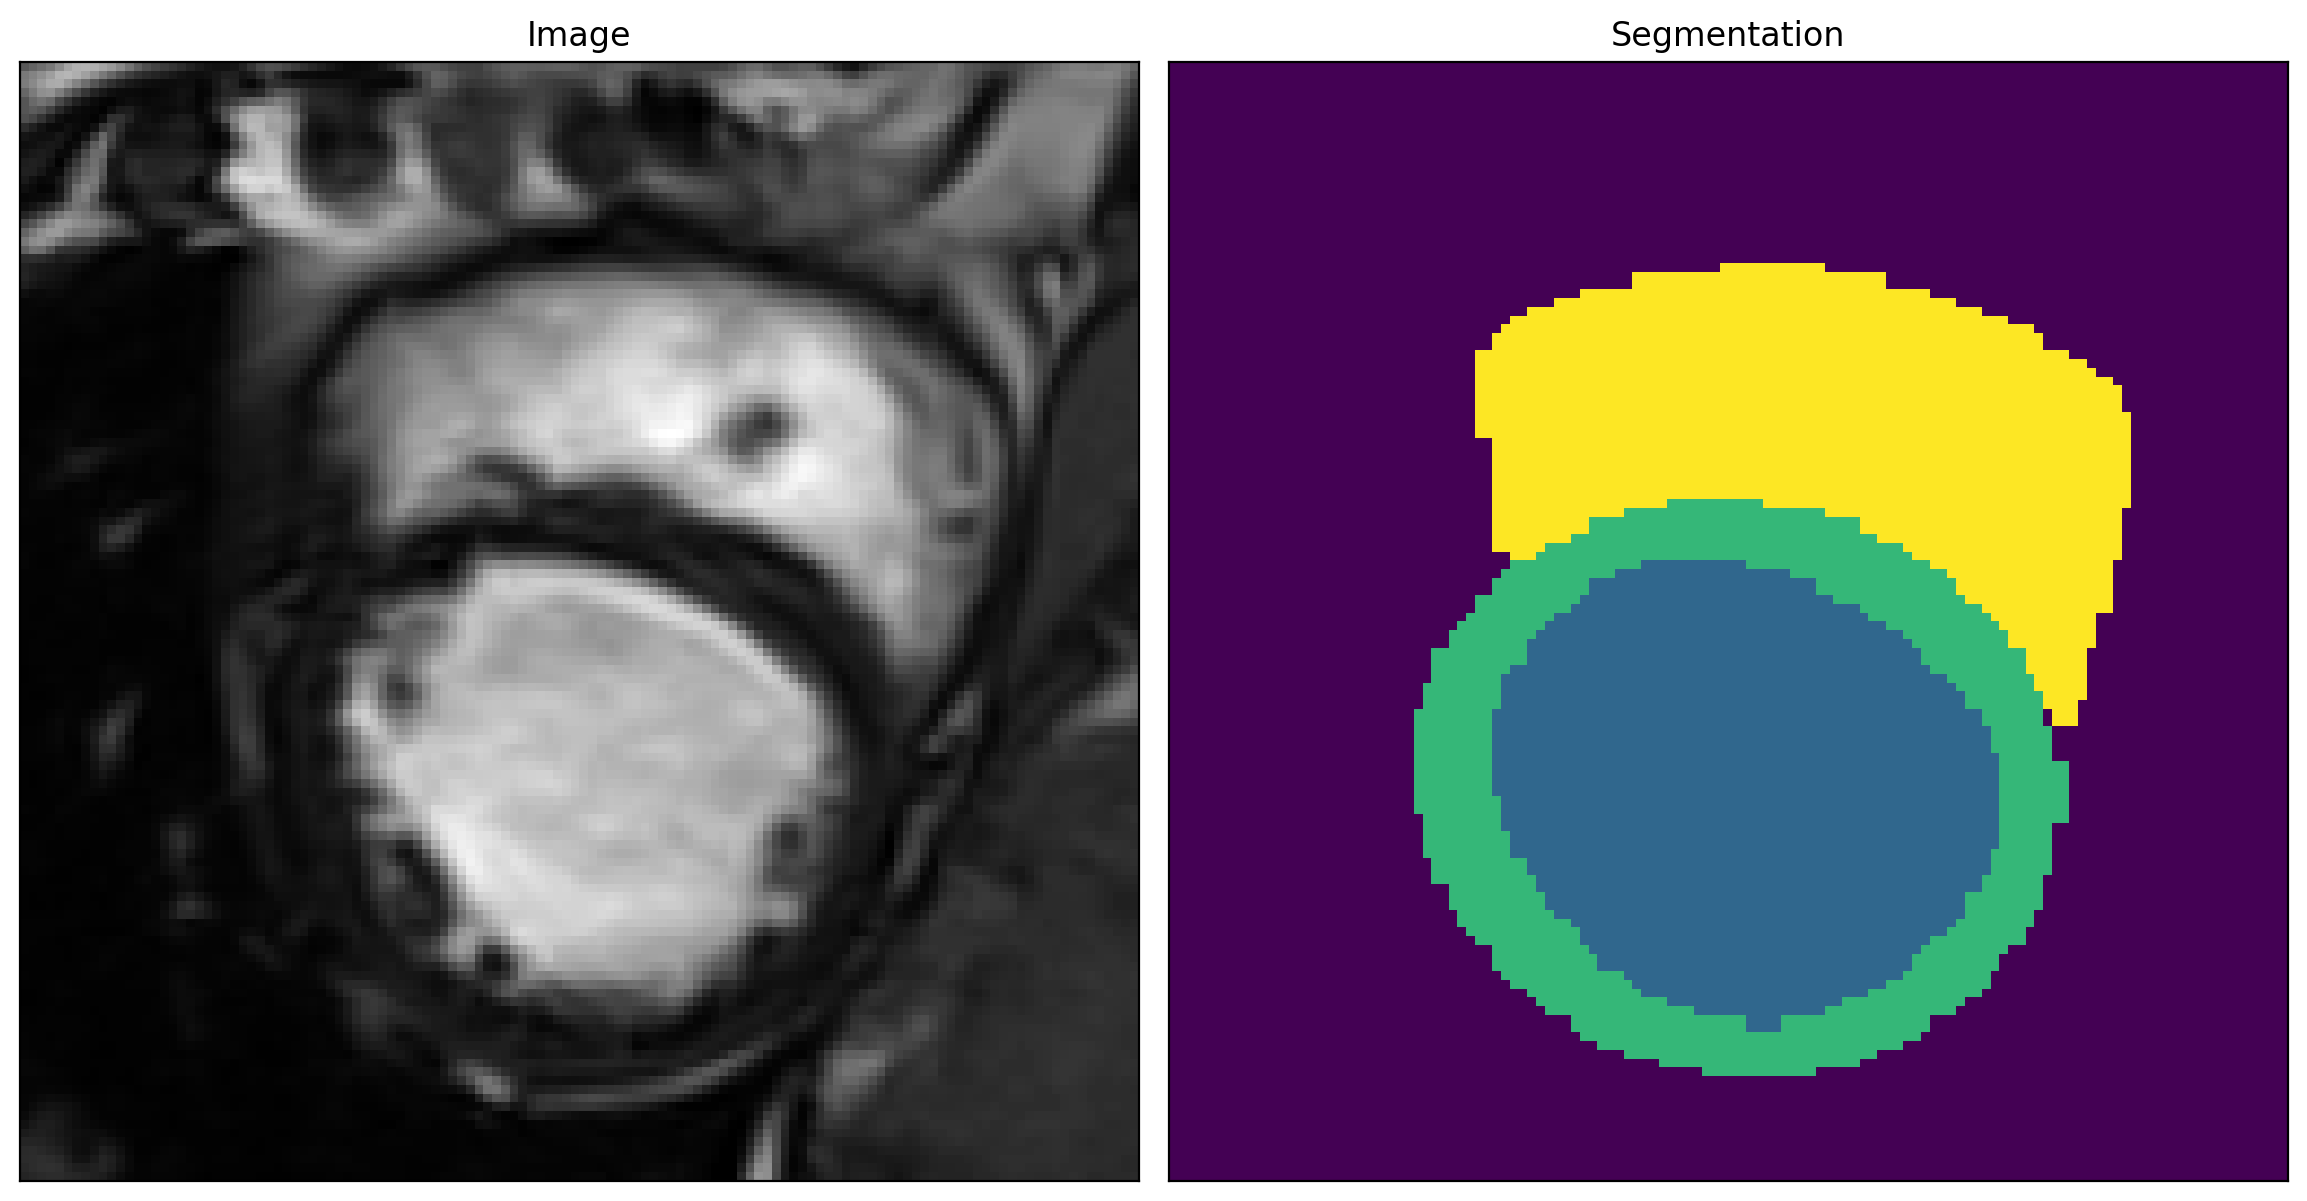

In [6]:
train_dataset = load_2D("Labeled/")
valid_dataset = load_2D("Validation/")

image = train_dataset[10][0]
seg = train_dataset[10][1]
visualize_slice(image, seg)

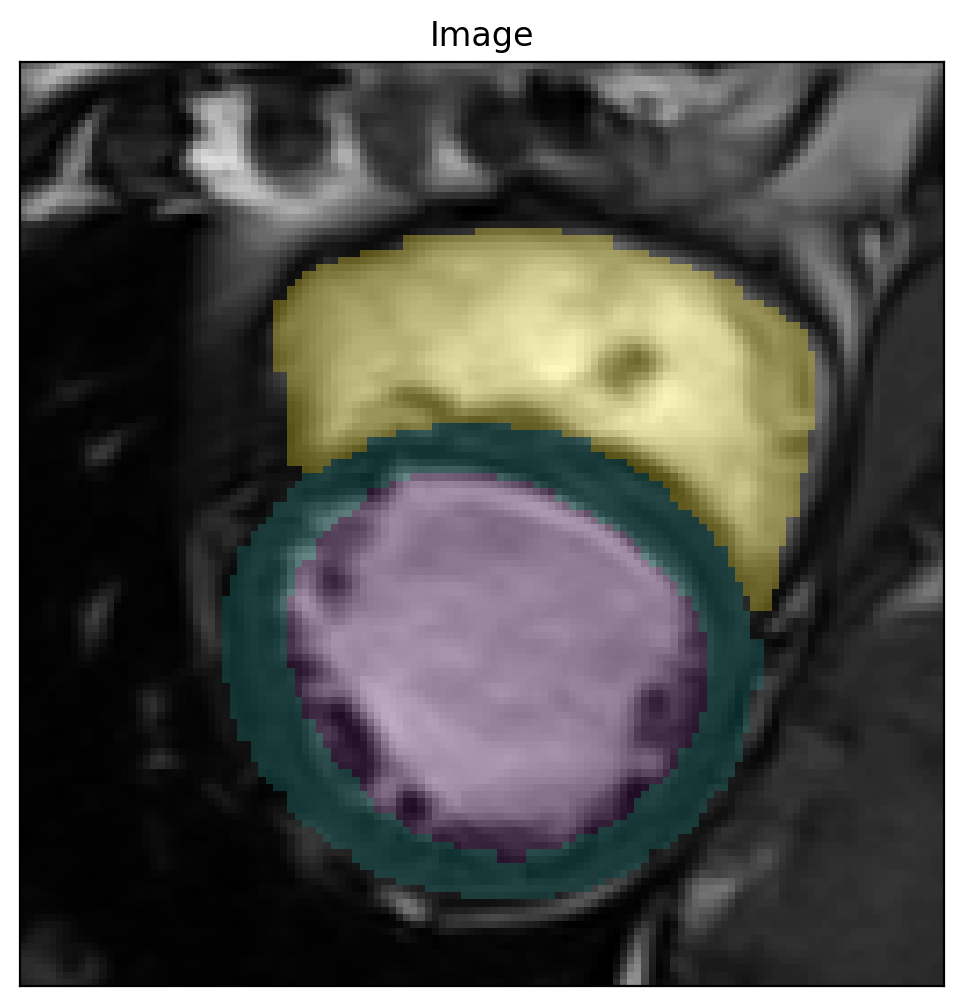

In [7]:
visualize_slice(image, seg, overlay=True, alpha=0.3)

# Unet

### Training

In [8]:
model = UNet(
    in_channels=1,
    out_classes=4,
    dimensions=2,
    num_encoding_blocks=5,
    out_channels_first_layer=16,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
)

optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [9]:
num_epochs = 30
batch_size = 32
num_classes = 4
num_workers = 10
save = True
model_name = 'modelv4'

#model = train_model(model, 
                    # optimizer, 
                    # criterion, 
                    # device,  
                    # train_dataset, 
                    # valid_dataset,
                    # batch_size=batch_size,
                    # num_workers=num_workers,
                    # num_epochs=num_epochs,
                    # verbose=3,
                    # save=save,
                    # model_name= model_name
                    # )

In [10]:
save=True
model_name = "modelv4"
if save:
    checkpoint = torch.load(f'models/{model_name}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    meta = checkpoint['metadata']
    num_epochs = meta['num_epochs']
    total_steps = meta['total_steps']
    train_losses = meta['train_losses']
    valid_losses = meta['valid_losses']

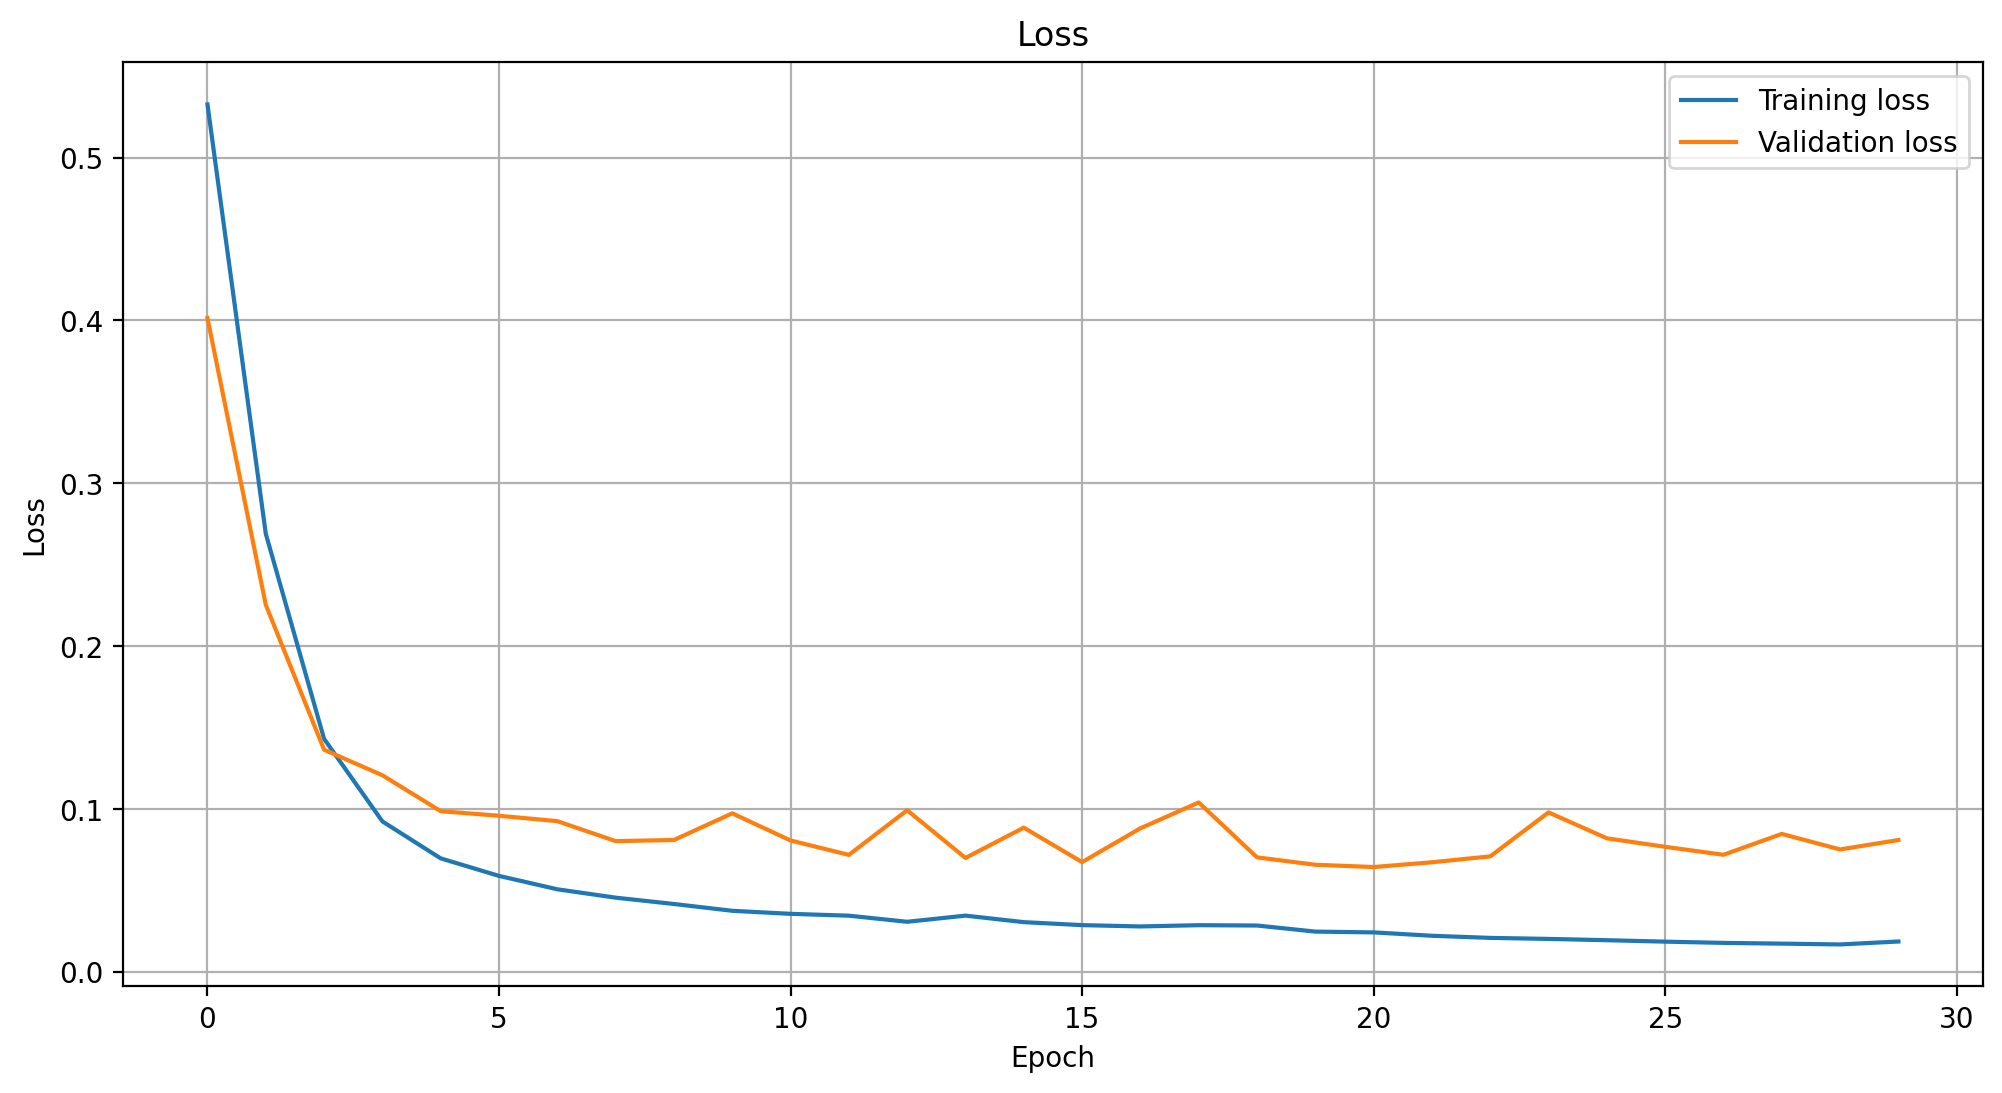

In [11]:
plt.plot(range(num_epochs) , train_losses, label="Training loss")
plt.plot(range(num_epochs) , valid_losses, label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Visualize results

In [12]:
images, labels = valid_dataset[:][0], valid_dataset[:][1]
predictions = predict(model, images, device)

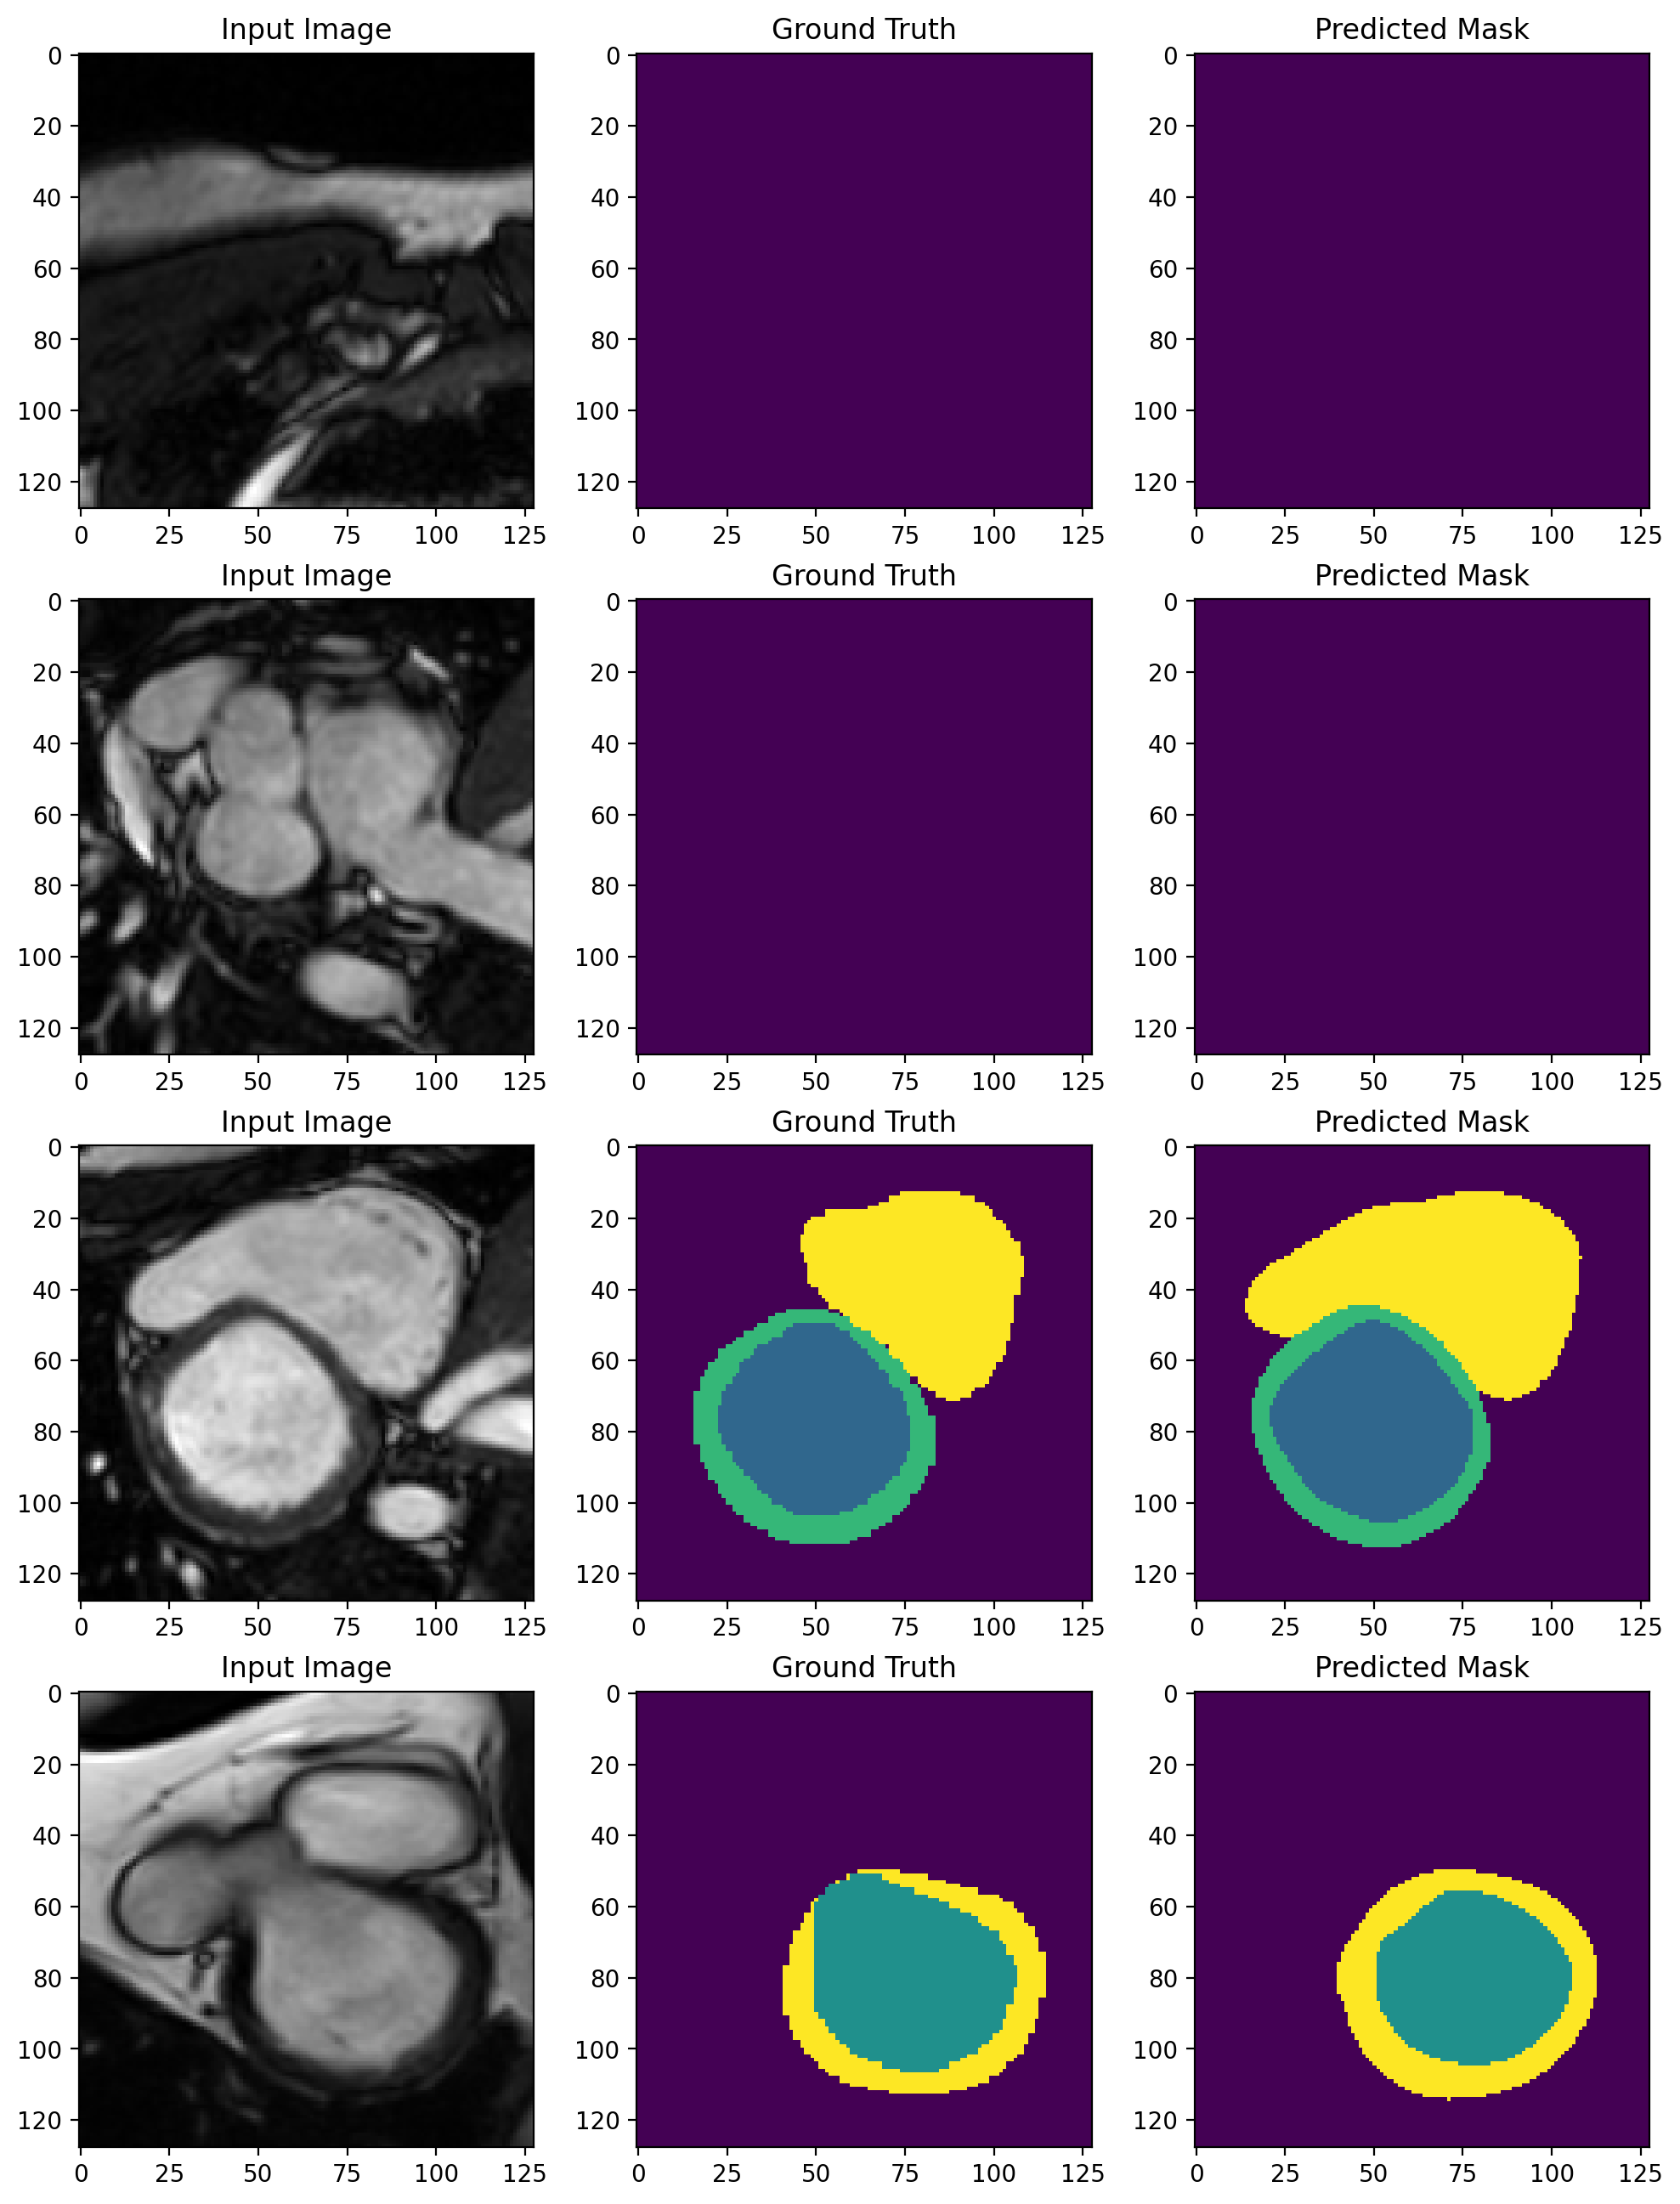

In [13]:
n_examples = 4
step = 20
visualize_predictions(images, labels, predictions, n_examples, step)

Vendor: D


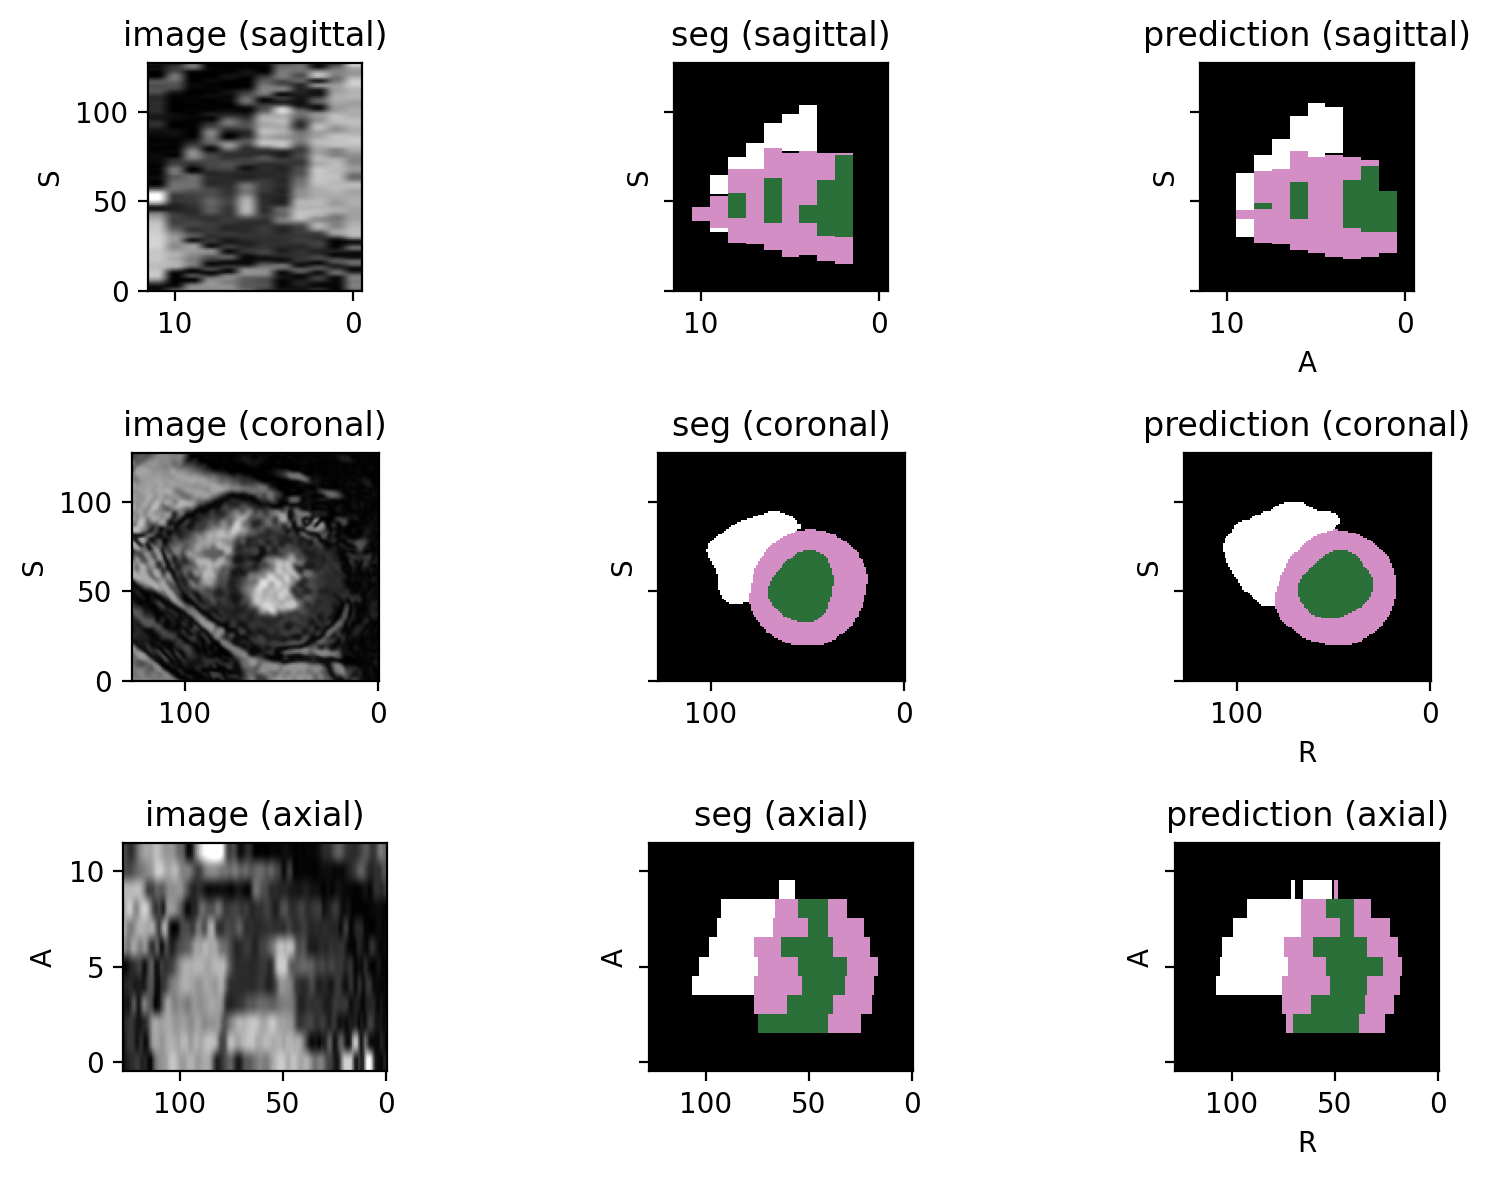

In [14]:
# Get data for one subject
one_subject = test_dataset_3D[10]
vendor = metadata.loc[one_subject.id].Vendor
print("Vendor:", vendor)
visualize_predictions_3D(model, one_subject, device)

### Evaluation Metrics

In [45]:
results = metadata[['Vendor', 'Centre']].copy()
results = results.assign(Dataset=None)

results = results.assign(Dice_BG=None, Dice_LV=None, Dice_RV=None, Dice_MYO=None)
results = results.assign(IoU_BG=None, IoU_LV=None, IoU_RV=None, IoU_MYO=None)
results = results.assign(HD_BG=None, HD_LV=None, HD_RV=None, HD_MYO=None)


results.head(5)

,Vendor,Centre,Dataset,Dice_BG,Dice_LV,Dice_RV,Dice_MYO,IoU_BG,IoU_LV,IoU_RV,IoU_MYO,HD_BG,HD_LV,HD_RV,HD_MYO
External code,,,,,,,,,,,,,,,
A0S9V9,A,1,None,None,None,None,None,None,None,None,None,None,None,None,None
A1D0Q7,B,2,None,None,None,None,None,None,None,None,None,None,None,None,None
A1D9Z7,A,1,None,None,None,None,None,None,None,None,None,None,None,None,None
A1E9Q1,A,1,None,None,None,None,None,None,None,None,None,None,None,None,None
A1K2P5,D,5,None,None,None,None,None,None,None,None,None,None,None,None,None


In [51]:
names = ["Train", "Valid", "Test"]
dataset_ids = [0, 1, 2]
datasets = [train_dataset_3D, valid_dataset_3D, test_dataset_3D]

for dataset_3D, name in zip(datasets, names):
    for i in range(len(dataset_3D)):
        # Get data for one subject
        subject = dataset_3D[i]
        labels = subject.seg.data 
        id = subject.id
        vendor = metadata.loc[id].Vendor
        
        # Make predictions
        c, x, y, z = labels.shape
        labels_stacked = labels.permute((0,3,1,2)).reshape(c*z ,x, y).long()
        predictions = predict_3D(model, subject, device)

        # Run multi-class evaluation
        dc = list(evaluate(labels_stacked, predictions, metric="Dice", multi_class=True, n_classes=4))
        jc = list(evaluate(labels_stacked, predictions, metric="Jaccard", multi_class=True, n_classes=4))
        hd = list(evaluate(labels_stacked, predictions, metric="AHD", multi_class=True, n_classes=4))
                                      
        results.loc[id, results.columns[2:]]  = [name] + dc + jc + hd

In [52]:
results.head(5)

,Vendor,Centre,Dataset,Dice_BG,Dice_LV,Dice_RV,Dice_MYO,IoU_BG,IoU_LV,IoU_RV,IoU_MYO,HD_BG,HD_LV,HD_RV,HD_MYO
External code,,,,,,,,,,,,,,,
A0S9V9,A,1,Train,0.99262,0.96489,0.867226,0.935414,0.985349,0.932162,0.765577,0.878665,4.0,3.605551,5.0,4.472136
A1D0Q7,B,2,Train,0.990574,0.891272,0.870393,0.883041,0.981325,0.803869,0.770528,0.790576,3.605551,8.0,4.472136,45.585085
A1D9Z7,A,1,Train,0.98722,0.913333,0.87067,0.888501,0.974762,0.84049,0.770962,0.799372,4.690416,6.708204,5.385165,10.440307
A1E9Q1,A,1,Train,0.993195,0.95663,0.879045,0.947139,0.986483,0.916865,0.784192,0.899587,4.0,4.358899,4.123106,9.055385
A1K2P5,D,5,Test,0.987706,0.918518,0.852633,0.927228,0.975711,0.849315,0.743122,0.864329,4.0,5.09902,9.949874,6.324555


In [53]:
results.to_csv('results.csv', index=True)

In [76]:
results = pd.read_csv('results.csv', index_col=0)

In [77]:
grouped_by_vendor = results.groupby(['Dataset', 'Vendor', 'Centre']).mean()
grouped_by_vendor

Dice_BG   Dice_LV   Dice_RV  Dice_MYO    IoU_BG  \
Dataset Vendor Centre                                                     
Test    A      1       0.982807  0.918759  0.807498  0.875825  0.966272   
        B      2       0.981644  0.910043  0.811135  0.870760  0.964088   
               3       0.983747  0.919017  0.840992  0.857525  0.968095   
        C      4       0.981228  0.878786  0.772713  0.818129  0.963319   
        D      5       0.982324  0.889578  0.801817  0.860760  0.965368   
Train   A      1       0.992521  0.959372  0.896199  0.932368  0.985160   
        B      2       0.991971  0.946325  0.900405  0.934920  0.984077   
               3       0.992717  0.961830  0.888721  0.952845  0.985548   
Valid   A      1       0.985998  0.926759  0.852728  0.869972  0.972402   
        B      2       0.987634  0.929915  0.850920  0.914388  0.975577   
               3       0.991815  0.955215  0.857981  0.955762  0.983767   
        C      4       0.985061  0.907140  0.852166  0.882740  0.970604   
        D      5       0.978717  0.886463  0.770845  0.861738  0.958389   

                         IoU_LV    IoU_RV   IoU_MYO     HD_BG      HD_LV  \
Dataset Vendor Centre                                                      
Test    A      1       0.850785  0.679960  0.784890  4.689829   8.740483   
        B      2       0.836258  0.686046  0.779416  4.242997   7.151713   
               3       0.852271  0.727110  0.758763  6.001346   5.607044   
        C      4       0.789537  0.635458  0.718154  4.506994  13.122764   
        D      5       0.806848  0.671406  0.767900  3.986327   9.915855   
Train   A      1       0.922297  0.812290  0.874485  3.761853   3.764347   
        B      2       0.899004  0.819198  0.878426  4.407182   4.163428   
               3       0.926522  0.800410  0.910393  4.610732   3.325618   
Valid   A      1       0.864296  0.743624  0.772833  4.139816   7.161677   
        B      2       0.870876  0.740810  0.842876  5.541641   5.464911   
               3       0.914424  0.751836  0.915364  4.186021   3.386021   
        C      4       0.832088  0.743967  0.791488  5.178271  13.945093   
        D      5       0.797776  0.637291  0.760497  5.080381  17.538322   

                           HD_RV     HD_MYO  
Dataset Vendor Centre                        
Test    A      1        9.919599  15.406062  
        B      2       10.385026  12.106514  
               3        8.655501  15.777136  
        C      4       16.116581  21.363732  
        D      5       12.882765  19.556050  
Train   A      1        6.293264   7.786639  
        B      2        5.335808   6.894534  
               3        7.544302   6.802508  
Valid   A      1        9.320571   8.870138  
        B      2        7.154951  10.244467  
               3        7.340372   7.227282  
        C      4       12.408429  11.197843  
        D      5       16.560425  20.387285

# Train on only one Vendor 

In [29]:
vendors = list(metadata.Vendor.unique())
vendors

['A', 'B', 'D', 'C']

In [66]:
vendor_datasets_3D = []
for vendor in vendors:
    vendor_datasets_3D.append(load_vendor_3D(vendor, metadata))

0it [00:00, ?it/s]

317it [00:09, 34.63it/s]


Data/M&Ms/OpenDataset/ Dataset size: 95 subjects


317it [00:11, 26.68it/s]


Data/M&Ms/OpenDataset/ Dataset size: 125 subjects


317it [00:04, 67.52it/s] 


Data/M&Ms/OpenDataset/ Dataset size: 50 subjects


317it [00:04, 71.52it/s] 

Data/M&Ms/OpenDataset/ Dataset size: 47 subjects


In [67]:
# for i in range(4):
#     visualize_subject(vendor_datasets_3D[i][0])

In [56]:
A_dataset = load_vendor_2D("A", metadata)

0it [00:00, ?it/s]

317it [00:08, 35.66it/s]


Data/M&Ms/OpenDataset/ Dataset size: 2212 subjects


In [58]:
# Specify the sizes for the training and validation sets
train_size = int(0.8 * len(A_dataset))  # 80% for training
val_size = len(A_dataset) - train_size  # Remaining 20% for validation

# Split the dataset into train and validation sets
train_dataset, valid_dataset = torch.utils.data.random_split(A_dataset, [train_size, val_size])

# Print the lengths of the resulting datasets
print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(valid_dataset))

Train dataset length: 1769
Validation dataset length: 443


In [60]:
model = UNet(
    in_channels=1,
    out_classes=4,
    dimensions=2,
    num_encoding_blocks=5,
    out_channels_first_layer=16,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
)

optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [61]:
num_epochs = 30
batch_size = 32
num_classes = 4
num_workers = 10
save = True
model_name = 'A_dataset'

model = train_model(model, 
                    optimizer, 
                    criterion, 
                    device,  
                    train_dataset, 
                    valid_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    num_epochs=num_epochs,
                    verbose=3,
                    save=save,
                    model_name= model_name
                    )

  3%|▎         | 1/30 [00:11<05:41, 11.78s/it]

Epoch [1/30]], Loss: 0.4888, Validation Loss: 0.4371


 37%|███▋      | 11/30 [00:46<01:06,  3.52s/it]

Epoch [11/30]], Loss: 0.0487, Validation Loss: 0.0505


 70%|███████   | 21/30 [01:20<00:31,  3.48s/it]

Epoch [21/30]], Loss: 0.0287, Validation Loss: 0.0462


100%|██████████| 30/30 [01:52<00:00,  3.76s/it]


In [62]:
if save:
    checkpoint = torch.load(f'models/{model_name}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    meta = checkpoint['metadata']
    num_epochs = meta['num_epochs']
    total_steps = meta['total_steps']
    train_losses = meta['train_losses']
    valid_losses = meta['valid_losses']

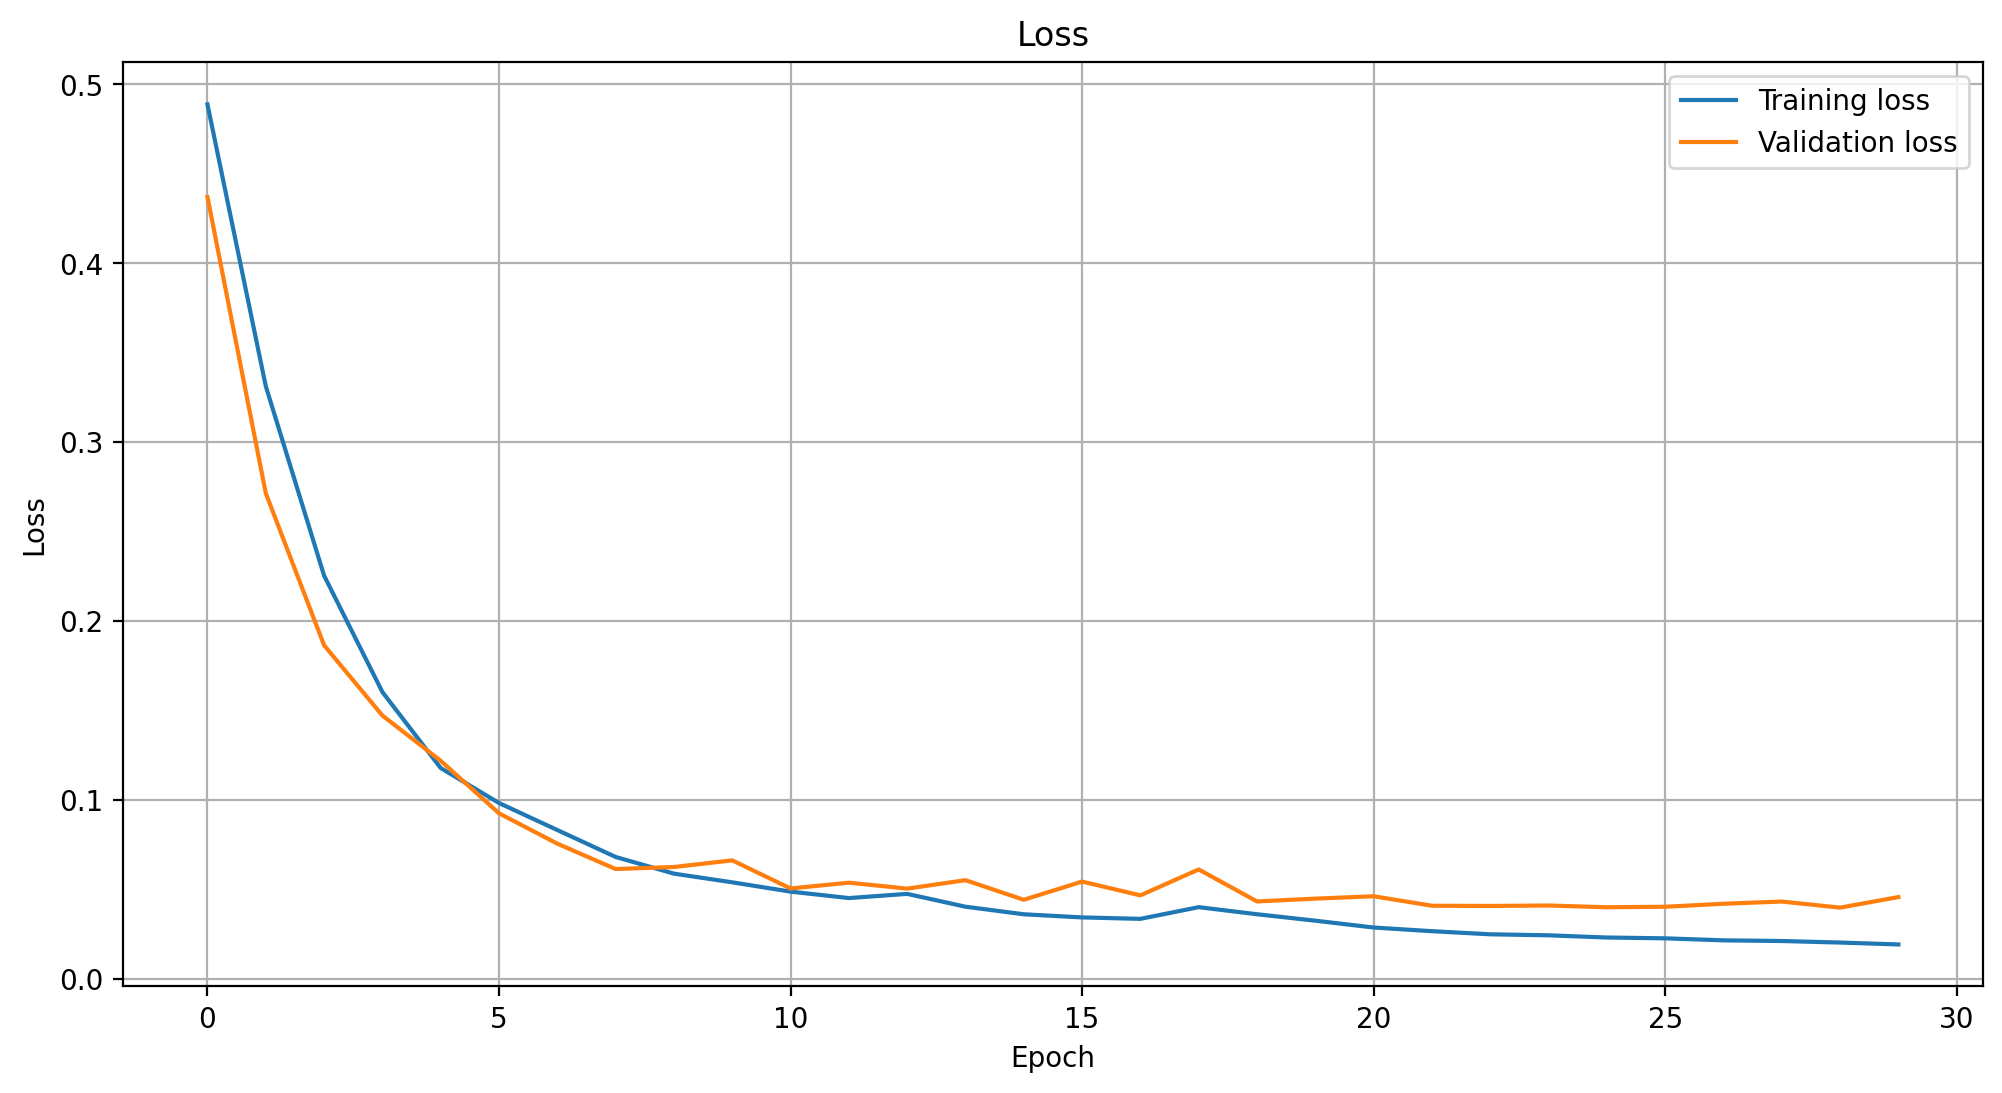

In [63]:
plt.plot(range(num_epochs) , train_losses, label="Training loss")
plt.plot(range(num_epochs) , valid_losses, label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend()
plt.show()

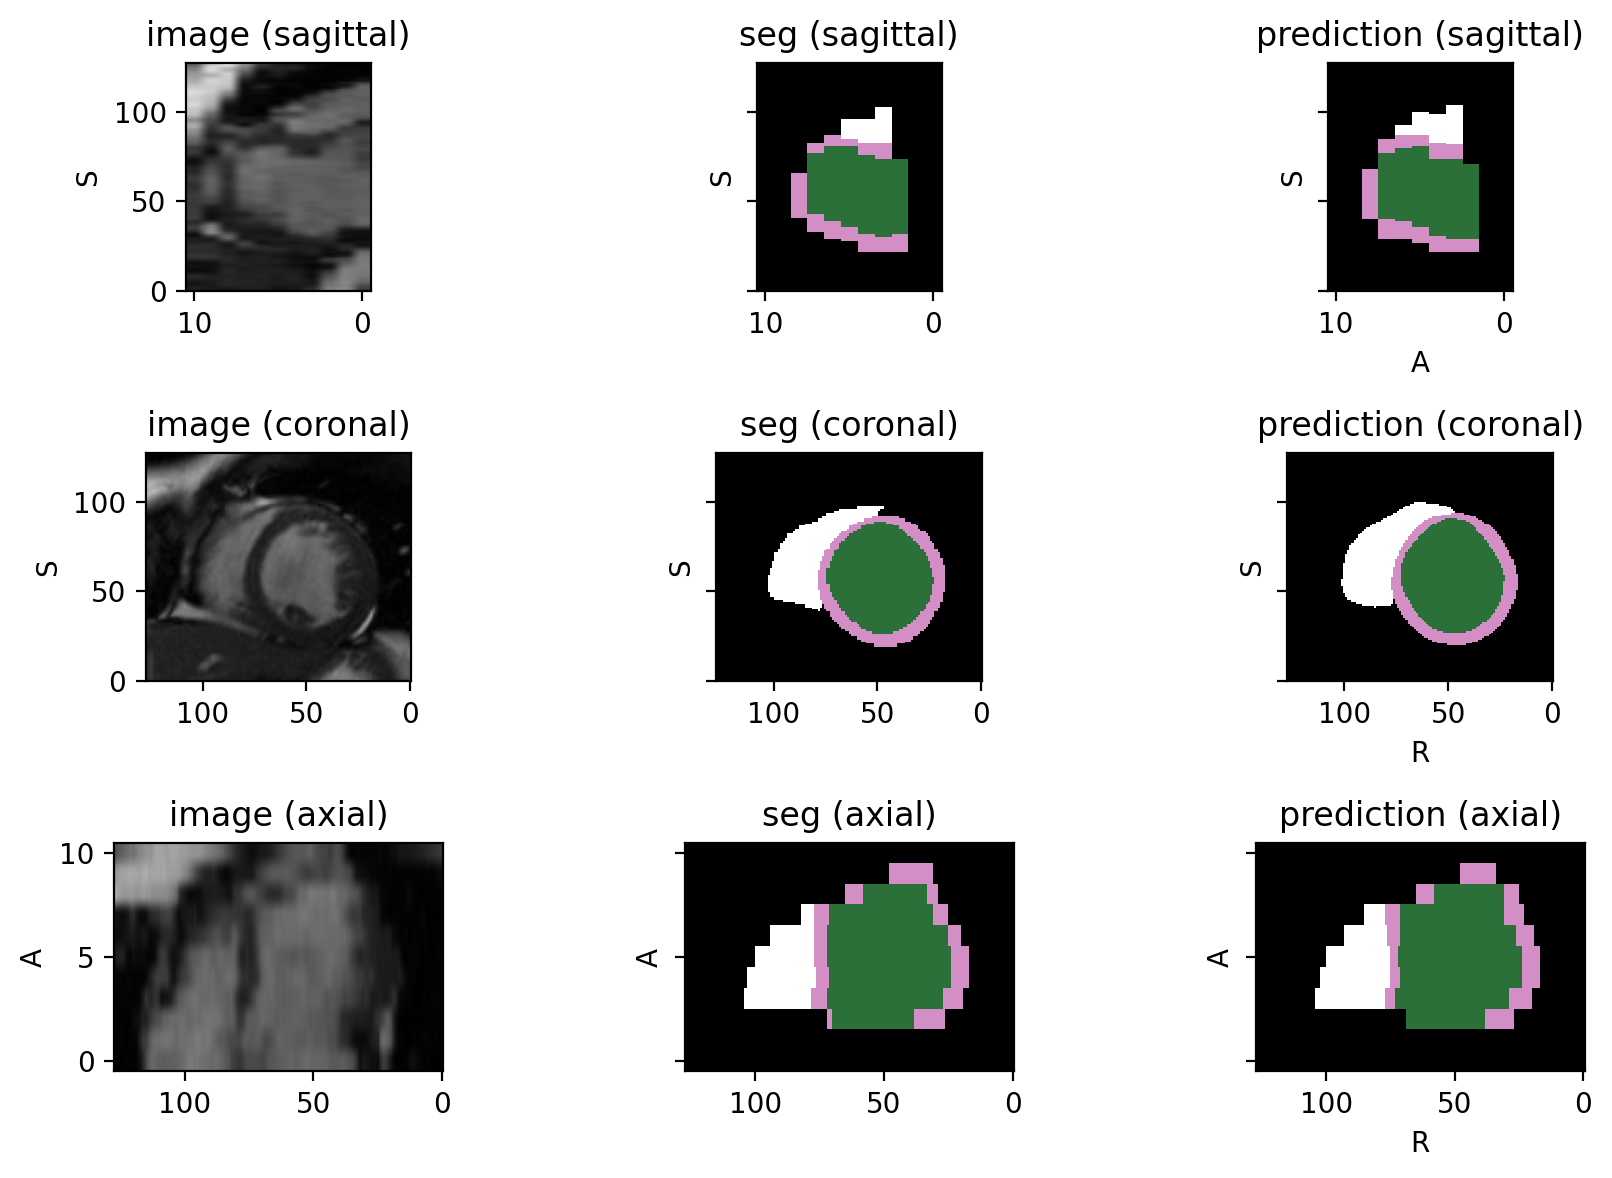

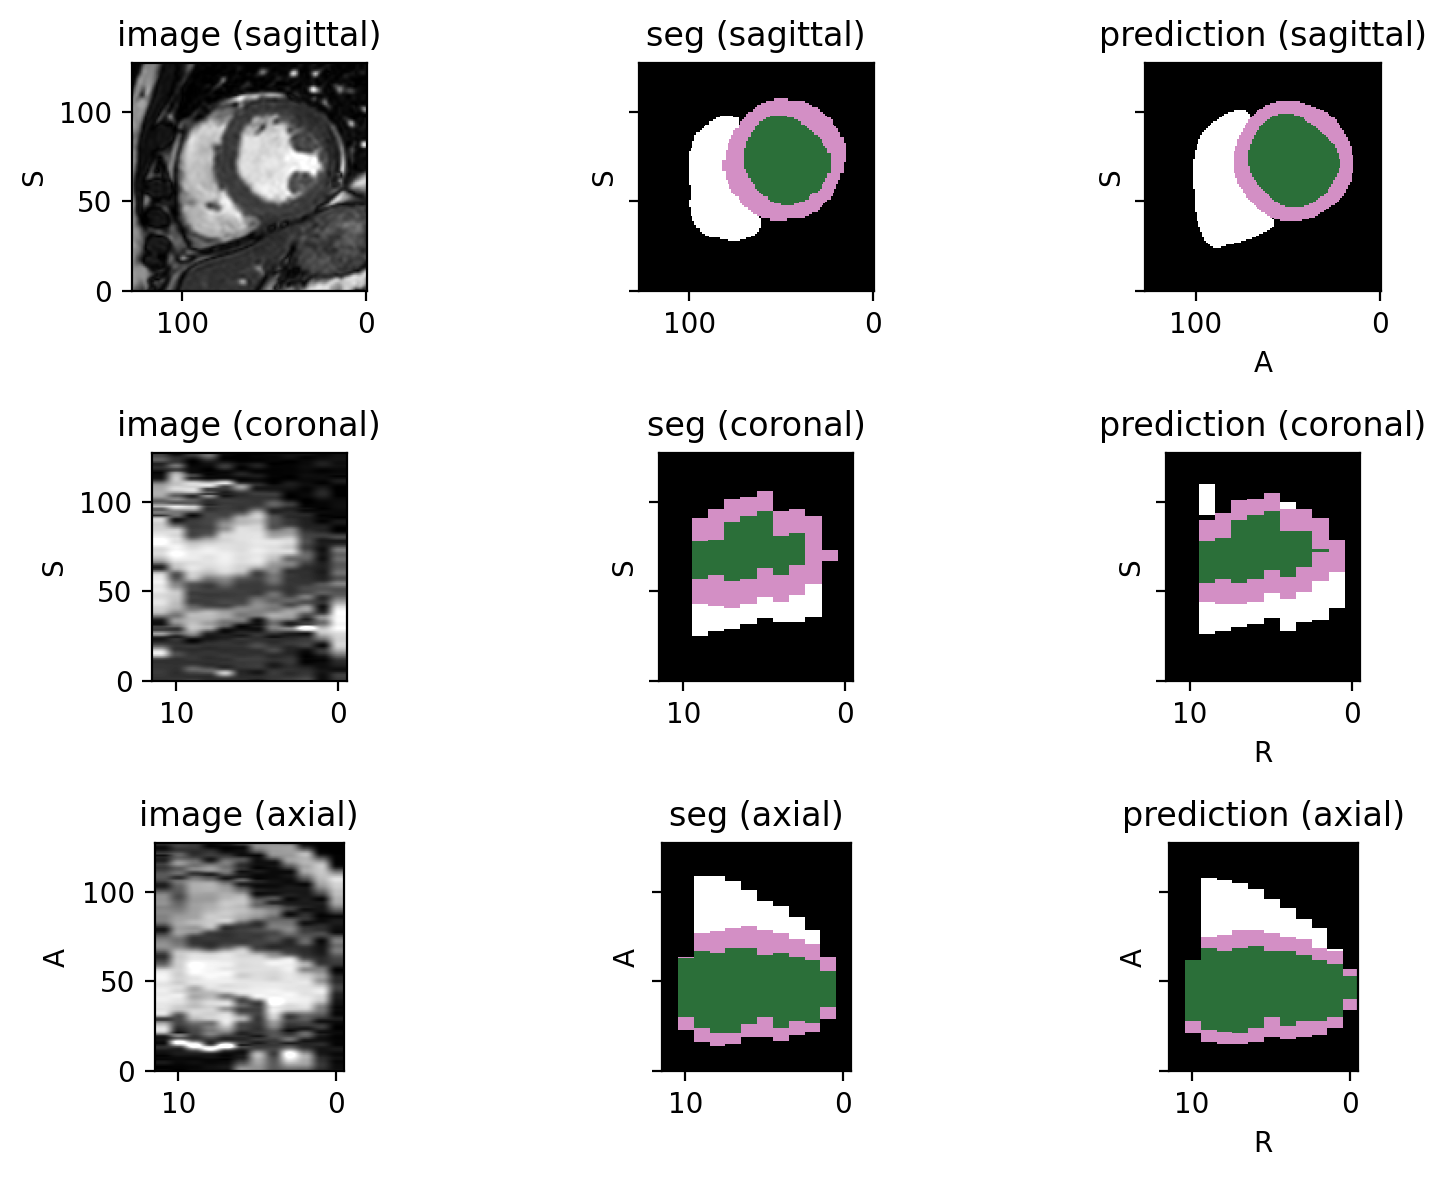

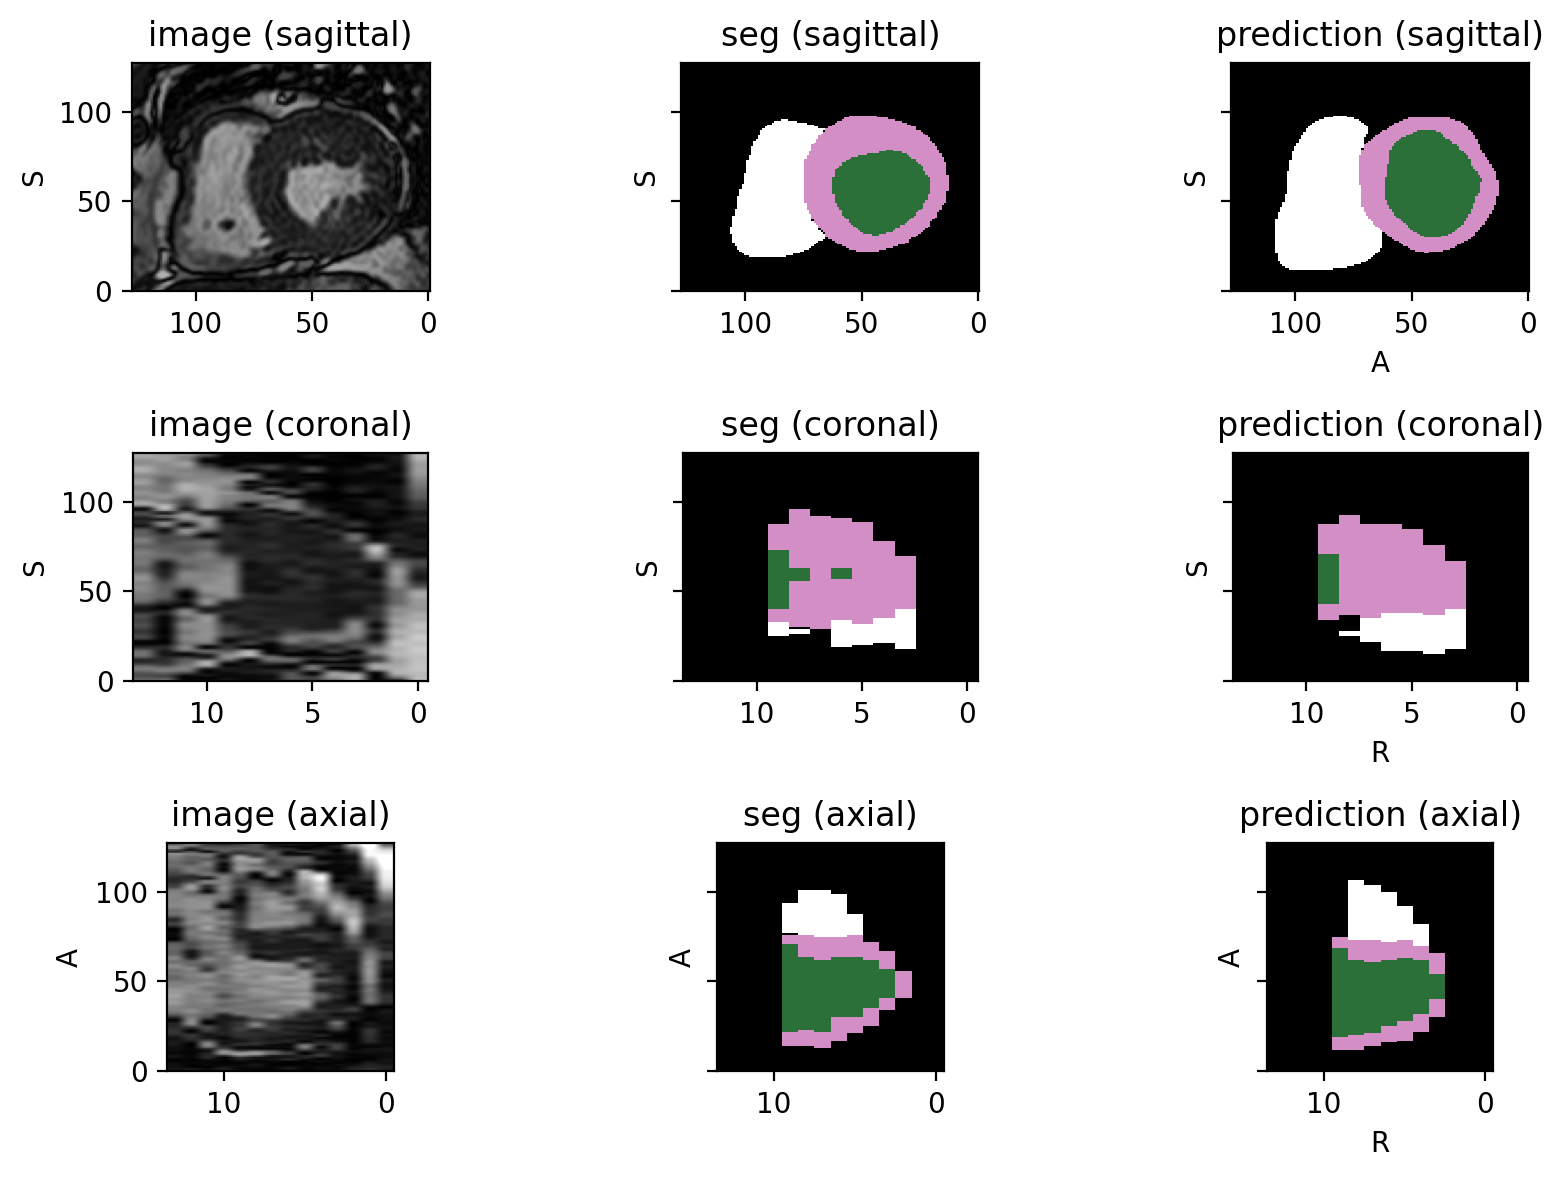

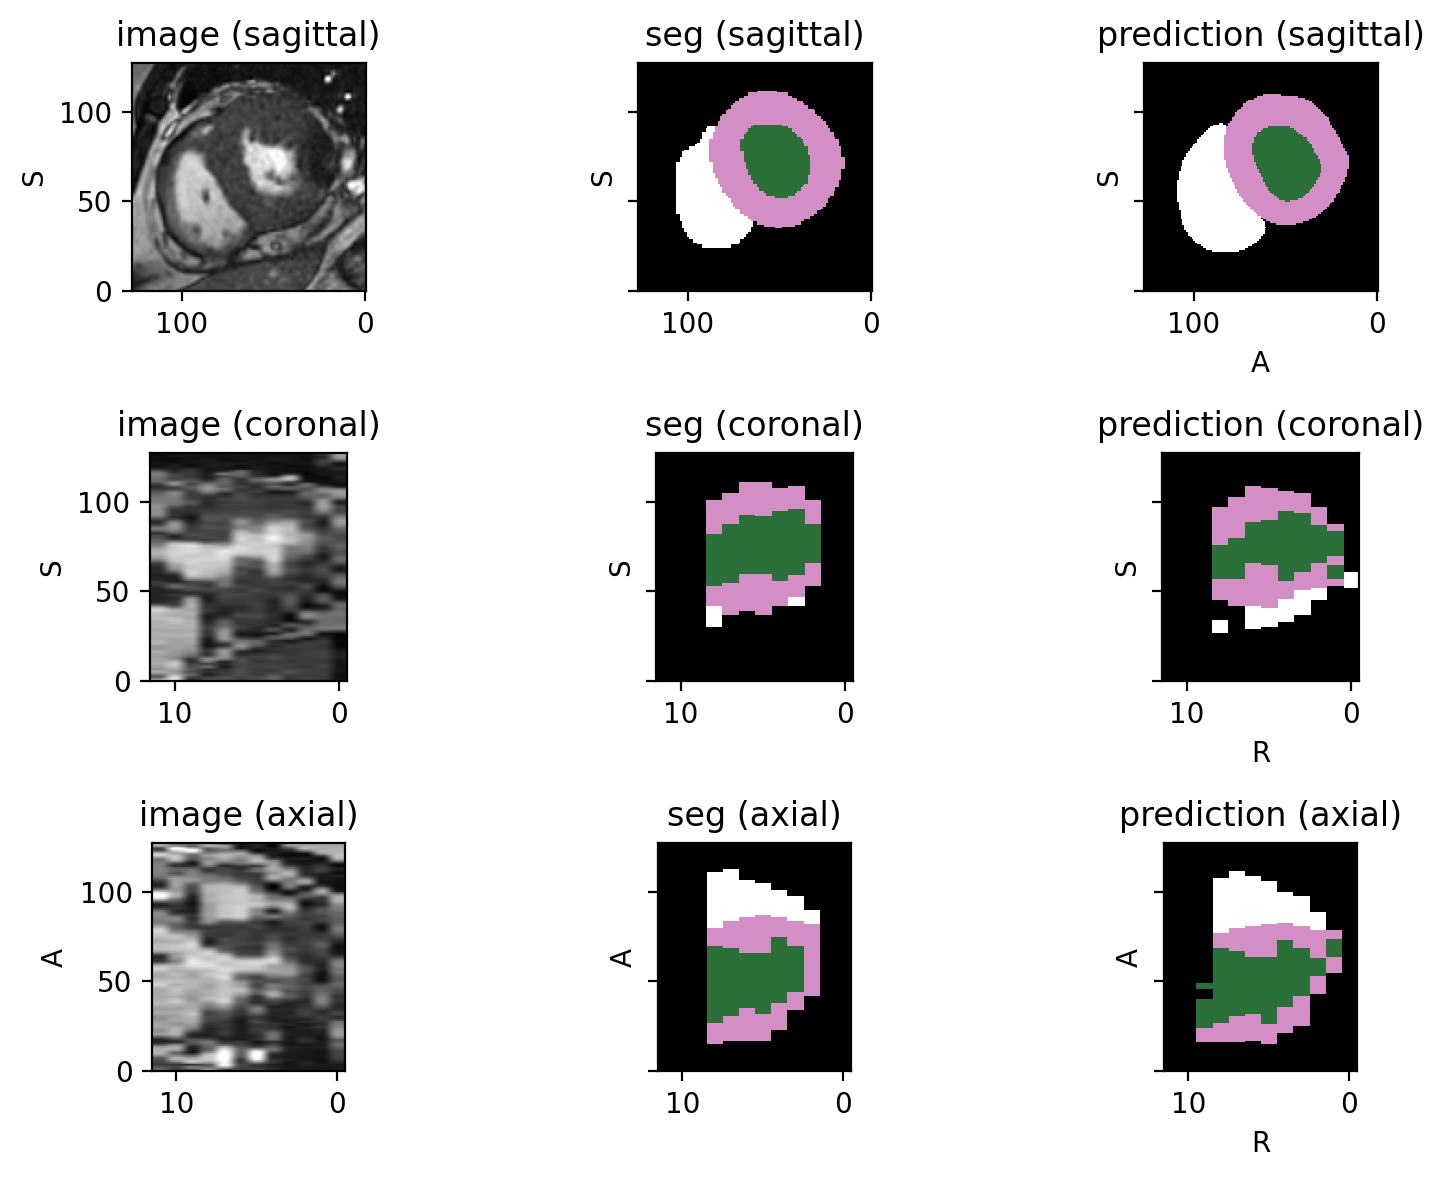

In [69]:
for i in range(4):
    # Get data for one subject
    one_subject = vendor_datasets_3D[i][0]
    visualize_predictions_3D(model, one_subject, device)

In [70]:
results = metadata[['Vendor', 'Centre']].copy()

results = results.assign(Dice_BG=None, Dice_LV=None, Dice_RV=None, Dice_MYO=None)
results = results.assign(IoU_BG=None, IoU_LV=None, IoU_RV=None, IoU_MYO=None)
results = results.assign(HD_BG=None, HD_LV=None, HD_RV=None, HD_MYO=None)


results.head(5)

,Vendor,Centre,Dice_BG,Dice_LV,Dice_RV,Dice_MYO,IoU_BG,IoU_LV,IoU_RV,IoU_MYO,HD_BG,HD_LV,HD_RV,HD_MYO
External code,,,,,,,,,,,,,,
A0S9V9,A,1,None,None,None,None,None,None,None,None,None,None,None,None
A1D0Q7,B,2,None,None,None,None,None,None,None,None,None,None,None,None
A1D9Z7,A,1,None,None,None,None,None,None,None,None,None,None,None,None
A1E9Q1,A,1,None,None,None,None,None,None,None,None,None,None,None,None
A1K2P5,D,5,None,None,None,None,None,None,None,None,None,None,None,None


In [71]:
for dataset_3D in vendor_datasets_3D:
    for i in range(len(dataset_3D)):
        # Get data for one subject
        subject = dataset_3D[i]
        labels = subject.seg.data 
        id = subject.id
        vendor = metadata.loc[id].Vendor
        
        # Make predictions
        c, x, y, z = labels.shape
        labels_stacked = labels.permute((0,3,1,2)).reshape(c*z ,x, y).long()
        predictions = predict_3D(model, subject, device)

        # Run multi-class evaluation
        dc = list(evaluate(labels_stacked, predictions, metric="Dice", multi_class=True, n_classes=4))
        jc = list(evaluate(labels_stacked, predictions, metric="Jaccard", multi_class=True, n_classes=4))
        hd = list(evaluate(labels_stacked, predictions, metric="AHD", multi_class=True, n_classes=4))
                                      
        results.loc[id, results.columns[2:]]  = dc + jc + hd

In [72]:
grouped_by_vendor = results.groupby(['Vendor', 'Centre']).mean()
grouped_by_vendor

Dice_BG   Dice_LV   Dice_RV  ...      HD_LV      HD_RV     HD_MYO
Vendor Centre                                ...                                 
A      1       0.992532  0.959896  0.900348  ...   3.695562   4.847883   6.555745
B      2       0.961285  0.672359  0.641509  ...  10.446436  11.959137  18.971645
       3       0.984115  0.927102  0.818332  ...   6.775076   8.230993  10.463269
C      4       0.975009  0.836737  0.712454  ...   9.373909  10.329859  19.739264
D      5         0.9781  0.879998   0.73592  ...    8.04848  10.884691  13.794813

[5 rows x 12 columns]

In [74]:
results.to_csv('results_A.csv', index=True)